In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
import itk
from matplotlib import pyplot as plt
import numpy as np
import pydicom
import sys
import cv2

In [3]:
def decompress_mamo_cases(directory):
    ics_filename = search_for_ics_filename(directory)
    if ics_filename == '':
        return []
    else:
        metadata = parse_ics_files(ics_filename)
    
    images = read_directory_contents(metadata, directory)
    
    return images


In [4]:
from os import listdir
from os.path import isfile, join
def search_for_ics_filename(directory):
  
    onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
    icsfiles  = [ (file) for file in onlyfiles if file.endswith(".ics")]
    return directory , icsfiles

In [5]:
search_for_ics_filename('/home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001')


('/home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001',
 ['C-0001-1.ics'])

In [6]:
import re

class image_file:
    def __init__(self,file_prefix, rows, columns, bpp, overl):
        self.file_prefix = file_prefix
        self.rows = rows
        self.columns = columns
        self.bpp = bpp
        self.overlay = overl
    
    def dump(self):
        return "File:" + self.file_prefix +"("+ str(self.rows) +"," + str(self.columns)+")"
            
class ics_struct:
    
    def __init__(self):
        self.files =[]
        
    def set_file(self,fil):        
        self.filename = fil
        
   
        
    def append_file(self,file_prefix, rows, columns, bpp, overl):
            f = image_file(file_prefix, rows, columns, bpp, overl)
            self.files.append(f)
        
    def set_patiend_age(self,age):
        self.patient_age = age
        
        
def parse_ics_files( dir_files_tuple):
    directory = dir_files_tuple[0]
    ics_files = dir_files_tuple[1]
    entries=[]
    for file in ics_files:   
        lines=[]
        with open(directory + "/" +file) as f:
            content = f.readlines()
            # you may also want to remove whitespace characters like `\n` at the end of each line
            content = [x.strip() for x in content] 
            if content != '':
                lines.append(content)
                
        #now we have the lines of a ics files
        #time to parse it
        #skip the first line   
        
        filename_regex = 'filename\s(.+)'
        patient_age_regex = 'PATIENT_AGE\s(\d+)'
        image_file_regex = '(\w+)\sLINES\s(\d+)\sPIXELS_PER_LINE\s(\d+)\sBITS_PER_PIXEL\s(\d+)\sRESOLUTION\s(\d+)\s(NON_OVERLAY|OVERLAY)'
        
        filename_prog = re.compile(filename_regex)
        patient_age_prog = re.compile(patient_age_regex)
        image_file_prog = re.compile(image_file_regex)
        
        ics = ics_struct()
        
        #the other type of lines are  irrelevant as of now...
        for line in lines[0]:
            #print(line)
            result = re.search(filename_regex,str(line))
            if result :
                #print("FOUND FILENAME:" + result.group(1))
                ics.set_file(result.group(1))
            else:
                result = re.match(patient_age_prog,str(line)) 
                if result :
                    #print("FOUND AGE:"+ result.group(1))
                    ics.set_patiend_age(int(result.group(1)))
                else:
                    result = re.match(image_file_prog,str(line) )
                    if result :
                        #print("FOUND FILE:"+ result.group(1))
                        ics.append_file(result.group(1), int(result.group(2)),int(result.group(3)), int(result.group(4)),result.group(5)=='OVERLAY')
        entries.append(ics)
        return entries
        #all lines done


In [7]:
ff = parse_ics_files(search_for_ics_filename('/home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001'))


In [8]:
[x.dump() for x in ff[0].files]

['File:LEFT_CC(4608,2928)',
 'File:LEFT_MLO(4592,2896)',
 'File:RIGHT_CC(4584,2920)',
 'File:RIGHT_MLO(4616,2888)']

In [9]:
import subprocess
import os
import shutil
def unpack_file(directory,filename,path_to_jpeg_tool,target_dir):    
    #print(path_to_jpeg_tool +" "+ directory+"/"+ filename)    
    process = subprocess.Popen(path_to_jpeg_tool + " " + directory+"/"+ filename, shell=True, stdout=subprocess.PIPE)    
    process.wait()        
    expected_output = directory+ "/" + filename +".1"
    target_output = target_dir+"/"+filename+".raw"
    print("Trying to move " + expected_output + " to " + target_output)
    shutil.move(expected_output, target_output)    
    return target_dir+"/"+filename+".raw"
  
    

In [10]:
ret = unpack_file('/home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001','C_0001_1.RIGHT_MLO.LJPEG',
            '/home/tiago/workspace/notebooks/execute_jpeg', '/tmp/tmp2')

Trying to move /home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001/C_0001_1.RIGHT_MLO.LJPEG.1 to /tmp/tmp2/C_0001_1.RIGHT_MLO.LJPEG.raw


FileNotFoundError: [Errno 2] No such file or directory: '/home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001/C_0001_1.RIGHT_MLO.LJPEG.1'

In [ ]:
# we now need to get the resulting image and render it as an image

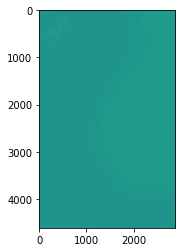

In [27]:

np.fromfile(ret)
A = np.fromfile(ret, dtype='>i2', sep="")
A = A.reshape(4616,2888)
plt.imshow(A)
plt.show()

In [28]:
def offset_img(img):
    mi = np.min(img)
    upimg = img.astype(np.uint16)
    tmp = [x - mi for x in upimg]
    return np.array(tmp).reshape(img.shape)
    

def window_it(img,center,width):
    imax = np.max(img)
    imin = np.min(img)
    ws = center - width//2
    we = center + width//2
    wd = we-ws
    factor = 255.0/wd
    
    nov = np.array([ (x - ws) * factor for x in np.clip(img,ws,we)]).astype(np.uint16)
    return nov.reshape(img.shape)

4

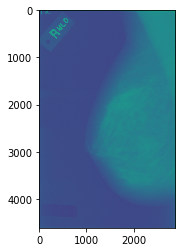

In [29]:
teste = window_it(A,3323,9374)
plt.imshow(teste)
plt.show()

In [151]:
def follow_overlay(coord,code):
    paths = {7:(-1,-1),0:(-1,0),1:(-1,1),6:(0,-1),2:(0,+1),5:(+1,-1),4:(+1,0),3:(+1,+1)}
    step = paths[code]
    return (coord[0]+step[0], coord[1] +step[1])

In [152]:
follow_overlay([45,31],7)


(44, 30)

In [206]:
class overlay:
    
    def __init__(self, filename, abnormalities):
        self.filename = filename
        self.abnormalities = abnormalities

class abnormality:
    
    def  fill(self,lesion_type, assessment, subtlety, pathology, total_outlines, lesion_start, lesion_track):
        self.lesion = lesion_type
        self.assessment = assessment
        self.subtlety = subtlety
        self.pathology = pathology
        self.total_outlines = total_outlines
        self.lesion_start = lesion_start
        self.lesion_track = lesion_track
        


def parse_lesion(path):
    splitage = path.split()
    result = [int(x) for x in splitage if x != '#']
    return result

In [209]:
def parse_overlay(filename):
    lines = []
    abnormalities=[]
    
    with open(filename) as f:
            content = f.readlines()
            # you may also want to remove whitespace characters like `\n` at the end of each line
            content = [x.strip() for x in content] 
            if content != '':
                lines.append(content)
    abnormalities_count_regex = 'TOTAL_ABNORMALITIES\s(.+)'
    abnormalities_count_prog =   re.compile(abnormalities_count_regex)
   
    result = re.search(abnormalities_count_prog,str(lines[0][0]))
    
    expected_abnormalities = 0
    if result :
        expected_abnormalities = int(result.group(1))
    line_index = 1
    
    lesion_type_regex = 'LESION_TYPE\s(.+)' # really hope this is greedy and include spaces
    lesion_type_prog =  re.compile(lesion_type_regex)
    assessment_regex = 'ASSESSMENT\s(\d+)'
    assessment_prog  = re.compile(assessment_regex)
    subtlety_regex   = 'SUBTLETY\s(\d+)'
    subtlety_prog    = re.compile(subtlety_regex)
    pathology_regex = 'PATHOLOGY\s(\w+)'
    pathology_prog = re.compile(pathology_regex)
    outlines_regex = 'TOTAL_OUTLINES\s(\d+)'
    outlines_prog = re.compile(outlines_regex)
    lesion_regex = '(\d+)\s(\d+)\s((\d\s)+)#'
    lesion_prog = re.compile(lesion_regex)
    
    
    while expected_abnormalities > 0 :
        abnormal_lines = lines[0][line_index:line_index+8]      
        abnormal = abnormality() 
        result0 = re.match(lesion_type_prog,str(abnormal_lines[1]))
        if result0 :
            #print("LESION TYPE:"+ result0.group(1))
            lesion_type = result0.group(1)
      
        result1 = re.match(assessment_prog,str(abnormal_lines[2]))
        if result1 :
            assessment = result1.group(1)
            #print("ASSESSMENT:"+ result1.group(1))
      
        result = re.match(subtlety_prog,str(abnormal_lines[3]))
        if result :
            subtlety = result.group(1)
            #print("SUBTLETY:"+ result.group(1))
      
        result = re.match(pathology_prog,str(abnormal_lines[4]))
        if result :
            pathology = result.group(1)
            #print("PATHOLOGY:"+ result.group(1))
      
        result = re.match(outlines_prog,str(abnormal_lines[5]))
        if result :
            outlines = result.group(1)
            #print("OUTLINES:"+ result.group(1))
      
        result = re.match(lesion_prog,str(abnormal_lines[7]))
        if result :
            #print("LESION:"+ result.group(1)+","+result.group(2)+"---"+result.group(3))
            lesion = parse_lesion(result.group(3))
            lesion_start = (int(result.group(1)),int(result.group(2)))
        abnormal.fill(lesion_type, assessment, subtlety, pathology, outlines, lesion_start, lesion)
        abnormalities.append(abnormal)
        expected_abnormalities -= 1
        line_index+=8
    return overlay(filename,abnormalities)
        
        
                
                    

In [211]:
seu_cromio = parse_overlay('/home/tiago/datasets/figment.csee.usf.edu/pub/DDSM/cases/cancers/cancer_01/case0001/C_0001_1.RIGHT_MLO.OVERLAY')

In [1]:
seu_cromio.abnormalities[0].lesion_start

NameError: name 'seu_cromio' is not defined

In [155]:
lines = ['dasdasda', 'aaaaa', 'bbbbbb', 'ccccccc', 'ddddddd', 'eeeeeeee' , 'ffffffff', 'ggggggggg', 'hhhhhhhhhhh']
lines[1:8]

['aaaaa', 'bbbbbb', 'ccccccc', 'ddddddd', 'eeeeeeee', 'ffffffff', 'ggggggggg']